In [1]:
import pandas

In [2]:
features = ["Alcohol", "Malic acid", "Ash", "Alcalinity of ash",
    "Magnesium", "Total phenols", "Flavanoids", "Nonflavanoid phenols",
    "Proanthocyanins", "Color intensity", "Hue",
    "OD280/OD315 of diluted wines", "Proline"]
target = 'Class'

# Load a Data Set

In hindsight this might have been a poor choice.

In [3]:
df = pandas.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', names=[target] + features)

In [4]:
df.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'Alcohol Content per Class')

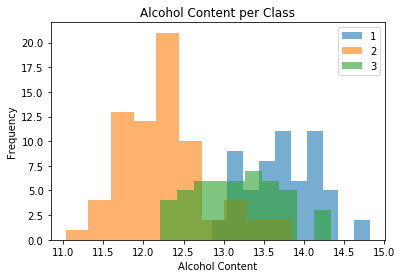

In [6]:
for c, d in df.groupby('Class'):
    d.Alcohol.plot.hist(label=c, alpha=0.6)
plt.legend()
plt.xlabel('Alcohol Content')
plt.title('Alcohol Content per Class')

# Find Feature Importance by Achieved Accuracy Score

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [8]:
train_data, test_data = train_test_split(df, test_size=0.2)

In [9]:
models = [KNeighborsClassifier(n_neighbors=5).fit(train_data[[f]], train_data[target]) for f in features]
scores = [accuracy_score(test_data[target], m.predict(test_data[[f]])) for m, f in zip(models, features)]

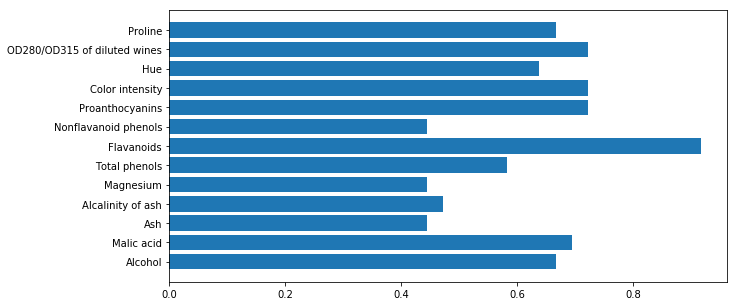

In [10]:
plt.barh(range(len(features)), scores)
plt.yticks(range(len(features)), features)
plt.gcf().set_size_inches(10, 5)
None

# Whicht k Should You Choose?

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
df_scaled = pandas.DataFrame(StandardScaler().fit_transform(df[features]), columns=features)
df_scaled[target] = df[target]

In [13]:
train_data_s, test_data_s = train_test_split(df_scaled, test_size=0.2)

In [14]:
N, _ = train_data_s.shape

In [15]:
ks = range(1, N+1)
models = [KNeighborsClassifier(n_neighbors=k).fit(train_data_s[features], train_data_s[target]) for k in ks]
scores = [accuracy_score(test_data_s[target], m.predict(test_data_s[features])) for m in models]

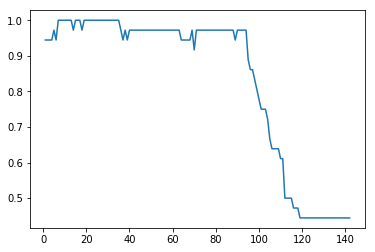

In [16]:
plt.plot(ks, scores)

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
neighbor_ks = range(1, 100)
untrained_models = [KNeighborsClassifier(n_neighbors=k) for k in neighbor_ks]

In [19]:
k_fold_scores = [cross_val_score(estimator=m, X=df_scaled[features], y=df_scaled[target], cv=10) for m in untrained_models]

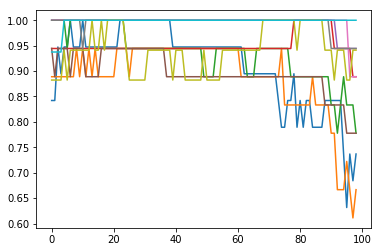

In [20]:
plt.plot(k_fold_scores)
None

<Container object of 3 artists>

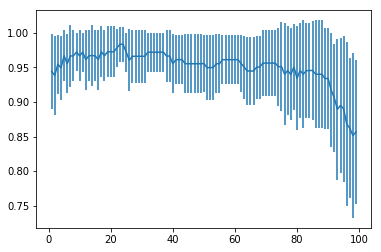

In [21]:
plt.errorbar(neighbor_ks, [s.mean() for s in k_fold_scores], yerr=[s.std() for s in k_fold_scores])